# BiciMAD
Practica de Sandra Fjelkestam, Greg Coletti, Lia Poidomani

We are about to analyse the dataset kindly offered by BiciMad at this link
https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1). 


In [29]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import statistics as stats
import json
from tabulate import tabulate

sc = SparkContext()

First we take a look at the structure of the data

In [6]:
!head -1 201812_Usage_Bicimad.json

The data comes in the structure above and each column in the database is decribed by the foloowing way. 

* _id: identification of the ride


* user_day_code: the user code. For same date, all the rides have the same code.


* idunplug_station: id number of the origin station


* idunplug_base: id number of origin base (a base is the "parking spot" for bike at the station)


* idplug_station: id number of destination station


* idplug_base: id number of destination base


* unplug_hourTime: time the bike is unpluged


* travel_time: time in seconds of the bikeride


* user_type: type of user. 
    it is defined as:
     - 0: not defined
     - 1: anual user
     - 2: ocasional user
     - 3: worker of bicimad


* ageRange: age range of the user.
    it is defined as
        - 0: not defined
        - 1: between 0 and 16 years
        - 2: between 17 and 18 years
        - 3: between 19 and 26 years
        - 4: between 27 and 40 years
        - 5: between 41 and 65 years
        - 6: more than 65 years


* zip_code: postal code of the user

Now we create the a mapper function to get a dictionary

In [7]:
rdd = {} #dictionary

In [8]:
def mapper(line):
    data = json.loads(line)
    #oid = data['oid']
    user_day_code = data['user_day_code']  
    idplug_base = data['idplug_base']
    user_type = data['user_type']
    idunplug_base = data['idunplug_base']
    travel_time = data ['travel_time']   
    start_station = data['idunplug_station']
    age = data['ageRange']
    end_station = data['idplug_station']
    year = data['unplug_hourTime']['$date'][0:4]
    month = data['unplug_hourTime']['$date'][5:7]
    day = data['unplug_hourTime']['$date'][8:10]
    hour = data['unplug_hourTime']['$date'][11:19]
    zip_code = data['zip_code']

    return {'user_day_code': user_day_code,
            'idplug_base': idplug_base,
            'user_type': user_type,
            'idunplug_base': idunplug_base,
            'travel_time': travel_time,
            'start_station': start_station,
            'end_station': end_station,
            'age': age,
            'year': year,
            'month': month,
            'day': day,
            'hour': hour,
            'zip_code': zip_code}

In [9]:
def file_name(i): #to get the file name
    if len(str(i)) == 1:
        file = '20180' + str(i)  + '_Usage_Bicimad.json'
    else:
        file = '2018' + str(i) + '_Usage_Bicimad.json'
    return file
    

we create a RDD dataset

In [30]:
rdd['2018'] = sc.emptyRDD()
file_list = []
for i in range(1,13):
    file_list.append(file_name(i))
     
print(file_list)
for filename in file_list:
    #We refer to the file with this format YYYYMM
    name = filename.split("_")[0]
    rdd[name] = sc.textFile(filename).map(mapper)
    rdd['2018'] = rdd['2018'].union(rdd[name])
    #DEBUG starts
    print(name)
    #DEBUG ends



['201801_Usage_Bicimad.json', '201802_Usage_Bicimad.json', '201803_Usage_Bicimad.json', '201804_Usage_Bicimad.json', '201805_Usage_Bicimad.json', '201806_Usage_Bicimad.json', '201807_Usage_Bicimad.json', '201808_Usage_Bicimad.json', '201809_Usage_Bicimad.json', '201810_Usage_Bicimad.json', '201811_Usage_Bicimad.json', '201812_Usage_Bicimad.json']
201801


In [17]:
#the stucture of our dataset
rdd['2018'].filter(lambda x: x['hour']=='18:00:00').take(1)

[{'user_day_code': '4a0786f7fef69c5b17b5975a41cce30f8519b41f07d35d4f171ea6d8801cfb58',
  'idplug_base': 10,
  'user_type': 1,
  'idunplug_base': 15,
  'travel_time': 211,
  'start_station': 118,
  'end_station': 160,
  'age': 0,
  'year': '2018',
  'month': '01',
  'day': '01',
  'hour': '18:00:00',
  'zip_code': ''}]



Now we do the same for the station's data. First we peek at the structure

In [14]:
!head -1 Bicimad_Stations_201812.json

#!head -1 Bicimad_Estacions_201807.json #DOES NOT WORK

head: Bicimad_Stations_201812.json: No such file or directory


In [117]:
rdd_station = {} #dictionary

In [118]:
def mapper_station(line):
    data = json.loads(line)
    activate = data['stations'][0]['activate']  
    name = data['stations'][0]['name']
    reservations_count = data['stations'][0]['reservations_count']
    light = data['stations'][0]['light']
    total_bases = data['stations'][0]['total_bases']   
    free_bases = data['stations'][0]['free_bases']
    number = data['stations'][0]['number']
    longitude = data['stations'][0]['longitude']
    no_available = data['stations'][0]['no_available']   
    address = data['stations'][0]['address']
    latitude = data['stations'][0]['latitude']
    dock_bikes = data['stations'][0]['longitude']
    iid = data['stations'][0]['id']
    
    return {#'activate': activate,
            'name': name,
            'reservations_count': reservations_count,
            'light': light,
            'total_bases': total_bases,
            'free_bases': free_bases,
            'number': number,
            'longitude': longitude,
            'no_available': no_available,
            'address': address,
            'latitude': latitude,
            'dock_bikes': dock_bikes,
            'id':iid}

In [119]:
rdd_station['2018'] = sc.emptyRDD()
file_list = ['Bicimad_Stations_201812.json']
#for i in range(1,13):
#    file_list.append(file_name(i))
#file_list[0] = 'Bicimad_Stations_201812.json'

for filename in file_list:
    #We refer to the file with this format YYYYMM
    name = filename.split('_')[2].split('.')[0]
    rdd_station[name] = sc.textFile(filename).map(mapper_station)
    rdd_station['2018'] = rdd_station['2018'].union(rdd_station[name])
    #DEBUG starts
    print(name)
    #DEBUG ends


201812


In [120]:
#the stucture of our dataset
rdd_station['2018'].take(10)

[{'name': 'Puerta del Sol A',
  'reservations_count': 0,
  'light': 2,
  'total_bases': 24,
  'free_bases': 13,
  'number': '1a',
  'longitude': '-3.7024255',
  'no_available': 0,
  'address': 'Puerta del Sol n� 1',
  'latitude': '40.4168961',
  'dock_bikes': '-3.7024255',
  'id': 1},
 {'name': 'Puerta del Sol A',
  'reservations_count': 0,
  'light': 2,
  'total_bases': 24,
  'free_bases': 7,
  'number': '1a',
  'longitude': '-3.7024255',
  'no_available': 0,
  'address': 'Puerta del Sol n� 1',
  'latitude': '40.4168961',
  'dock_bikes': '-3.7024255',
  'id': 1},
 {'name': 'Puerta del Sol A',
  'reservations_count': 0,
  'light': 2,
  'total_bases': 24,
  'free_bases': 15,
  'number': '1a',
  'longitude': '-3.7024255',
  'no_available': 0,
  'address': 'Puerta del Sol n� 1',
  'latitude': '40.4168961',
  'dock_bikes': '-3.7024255',
  'id': 1},
 {'name': 'Puerta del Sol A',
  'reservations_count': 0,
  'light': 0,
  'total_bases': 24,
  'free_bases': 16,
  'number': '1a',
  'longitude'

## Análisis del tipo de usuarios
In this section we analyse the variation among the different kind of users during the same period as before. BiciMAD saves the users in the following way:

1: annual membership user

2: occasional user

3: BiciMAD employee 


In [15]:
#Separate by user type
user_data = rdd['2018'].map(lambda x: x['user_type']).countByValue()
user_data

Traceback (most recent call last):                               (78 + 4) / 214]
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
22/05/22 17:25:15 ERROR Executor: Exception in task 77.0 in stage 1.0 (TID 78)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framewo

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 77 in stage 1.0 failed 1 times, most recent failure: Lost task 77.0 in stage 1.0 (TID 78) (gregorios-air.technicolor.net executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/var/folders/wy/p1h_rvg51y902qnr8y_3vmlh0000gn/T/ipykernel_24330/2955707407.py", line 2, in mapper
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/json/decoder.py", line 353, in raw_decode
    obj, end = self.scan_once(s, idx)
json.decoder.JSONDecodeError: Expecting ',' delimiter: line 1 column 1192 (char 1191)

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:680)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:434)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2019)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:269)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/var/folders/wy/p1h_rvg51y902qnr8y_3vmlh0000gn/T/ipykernel_24330/2955707407.py", line 2, in mapper
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/json/decoder.py", line 353, in raw_decode
    obj, end = self.scan_once(s, idx)
json.decoder.JSONDecodeError: Expecting ',' delimiter: line 1 column 1192 (char 1191)

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:307)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:680)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:434)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2019)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:269)


In [162]:
288111/59990


4.80265044174029

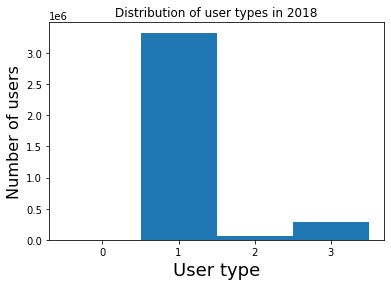

In [122]:
plt.title('Distribution of user types in 2018')
names = list(user_data.keys()) 
values = list(user_data.values())
plt.bar(names, values, 1)
plt.xlabel('User type', fontsize=18)
plt.ylabel('Number of users', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

In [168]:
user_data.values()

dict_values([3327888, 59990, 288111, 2097])

As expected, the most common user is the type 1. Surprinsingly not many people use it occasionaly, the employees are 4.8026 times more frequente than the casual users.

## Most popular stations
Both start and end stations.

In [123]:
#Separate by start station
start_station = rdd['2018'].map(lambda x: x['start_station']).countByValue()
start_data = sorted(dict(start_station).items(), key=lambda x:x[1], reverse=True)

In [81]:
start_data

[(135, 52550),
 (175, 50888),
 (43, 50659),
 (129, 49472),
 (163, 49366),
 (57, 48673),
 (149, 45099),
 (90, 42454),
 (168, 41935),
 (64, 40367),
 (162, 39129),
 (83, 38952),
 (160, 38529),
 (58, 37432),
 (9, 36326),
 (49, 35898),
 (132, 35406),
 (19, 33698),
 (128, 33688),
 (1, 33619),
 (108, 32613),
 (133, 32455),
 (170, 31975),
 (161, 31573),
 (59, 31514),
 (41, 31332),
 (38, 30819),
 (79, 30816),
 (46, 30601),
 (56, 30242),
 (31, 30224),
 (164, 29663),
 (6, 29369),
 (136, 29312),
 (166, 29095),
 (169, 28961),
 (74, 28819),
 (13, 28706),
 (84, 27867),
 (52, 27789),
 (114, 27225),
 (26, 27223),
 (139, 27025),
 (82, 26766),
 (53, 26444),
 (95, 26283),
 (42, 25728),
 (157, 25676),
 (91, 25198),
 (78, 25116),
 (30, 24987),
 (131, 24645),
 (75, 24521),
 (113, 24507),
 (62, 23738),
 (3, 23523),
 (55, 23321),
 (134, 23220),
 (118, 22932),
 (155, 22781),
 (65, 22769),
 (77, 22428),
 (76, 22350),
 (145, 22042),
 (156, 21946),
 (115, 21858),
 (73, 21843),
 (130, 21805),
 (71, 21623),
 (103, 2

In [124]:
#Separate by end station
end_station = rdd['2018'].map(lambda x: x['end_station']).countByValue()
end_data = sorted(dict(end_station).items(), key=lambda x:x[1], reverse=True) 

In [18]:
end_data

[(43, 3314),
 (175, 3240),
 (129, 3229),
 (57, 3153),
 (135, 3050),
 (163, 2916),
 (168, 2764),
 (149, 2756),
 (90, 2608),
 (83, 2518),
 (64, 2493),
 (162, 2492),
 (160, 2473),
 (49, 2418),
 (45, 2380),
 (9, 2359),
 (58, 2242),
 (108, 2184),
 (132, 2110),
 (59, 2049),
 (133, 2043),
 (79, 2026),
 (74, 2005),
 (128, 1991),
 (164, 1980),
 (1, 1911),
 (42, 1909),
 (13, 1895),
 (41, 1885),
 (161, 1884),
 (170, 1834),
 (56, 1833),
 (52, 1812),
 (26, 1802),
 (6, 1796),
 (75, 1766),
 (166, 1755),
 (95, 1752),
 (31, 1742),
 (78, 1734),
 (169, 1730),
 (38, 1722),
 (113, 1699),
 (19, 1658),
 (136, 1643),
 (131, 1631),
 (82, 1622),
 (46, 1621),
 (30, 1600),
 (91, 1595),
 (84, 1589),
 (23, 1587),
 (48, 1569),
 (65, 1563),
 (114, 1552),
 (62, 1521),
 (77, 1510),
 (134, 1499),
 (71, 1497),
 (55, 1488),
 (86, 1469),
 (157, 1460),
 (115, 1457),
 (139, 1452),
 (130, 1446),
 (99, 1444),
 (76, 1401),
 (118, 1386),
 (110, 1368),
 (106, 1357),
 (69, 1356),
 (3, 1337),
 (155, 1332),
 (145, 1319),
 (17, 1302)

In [128]:
start_table = [['Start station', 'No. of trips'],
         [start_data[0:10][0][0], start_data[0:10][0][1]],
         [start_data[0:10][1][0], start_data[0:10][1][1]],
         [start_data[0:10][2][0], start_data[0:10][2][1]],
         [start_data[0:10][3][0], start_data[0:10][3][1]],
         [start_data[0:10][4][0], start_data[0:10][4][1]],
         [start_data[0:10][5][0], start_data[0:10][5][1]],
         [start_data[0:10][6][0], start_data[0:10][6][1]],
               
         [start_data[0:10][7][0], start_data[0:10][7][1]],
         [start_data[0:10][8][0], start_data[0:10][8][1]],
         [start_data[0:10][9][0], start_data[0:10][9][1]]]
print(tabulate(start_table))

-------------  ------------
Start station  No. of trips
135            52550
175            50888
43             50659
129            49472
163            49366
57             48673
149            45099
90             42454
168            41935
64             40367
-------------  ------------


In [129]:
end_table = [['End station', 'No. of trips'],
         [end_data[0:10][0][0], end_data[0:10][0][1]],
         [end_data[0:10][1][0], end_data[0:10][1][1]],
         [end_data[0:10][2][0], end_data[0:10][2][1]],
         [end_data[0:10][3][0], end_data[0:10][3][1]],
         [end_data[0:10][4][0], end_data[0:10][4][1]],
         [end_data[0:10][5][0], end_data[0:10][5][1]],
         [end_data[0:10][6][0], end_data[0:10][6][1]],
         [end_data[0:10][7][0], end_data[0:10][7][1]],
         [end_data[0:10][8][0], end_data[0:10][8][1]],
         [end_data[0:10][9][0], end_data[0:10][9][1]]]
print(tabulate(end_table))

-----------  ------------
End station  No. of trips
135          53898
175          51297
43           51242
129          50132
163          49562
57           48394
149          44970
90           42724
168          42348
64           40068
-----------  ------------


In [130]:
#get the name of each station with help from rdd_stations
station_info = rdd_station['2018'].map(lambda x: x['id']==end_data[0][0]).countByValue()
list(station_info.keys())

[False]

They are the same for both end stations and start stations. 



## Analysis of monthly travels


In [174]:
list_month=['01','02','03','04','05','06','07','08','09','10','11','12']

daily_trips = rdd['2018'].map(lambda x: x['month']).countByValue()
for month in list_month:
    rdd_aux = rdd['2018'].filter(lambda x: x['month']==month)
    total_day = len(list(rdd_aux.map(lambda x: x['day']).countByValue()))
    daily_trips[month] = daily_trips[month]/total_day

print(daily_trips)



defaultdict(<class 'int'>, {'01': 8512.225806451614, '02': 8289.392857142857, '03': 6957.8387096774195, '04': 9914.566666666668, '05': 10341.67857142857, '06': 12111.074074074075, '07': 12337.193548387097, '08': 9468.896551724138, '09': 14545.266666666666, '10': 12444.290322580646, '11': 10004.366666666667, '12': 8809.516129032258})


In [181]:
l = list(daily_trips.values())

In [216]:
winter = sum(l[0:3]) #jan, feb, march
spring = sum(l[3:6]) #april, may, june
summer = sum(l[6:9]) #july, ,august, september
autumn = sum(l[9:12]) #october, november, december

[12444.290322580646, 10004.366666666667, 8809.516129032258]

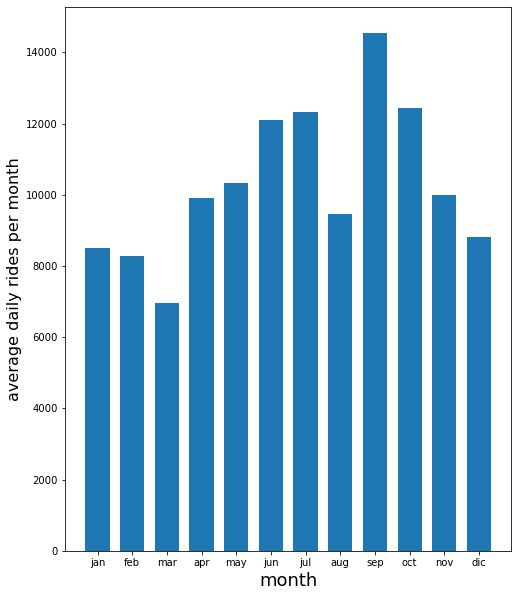

In [219]:
plt.figure(figsize=(8,10))
plt.title('')
names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dic'] 
values = list(daily_trips.values())
plt.bar(names, values, width=0.7)
plt.xlabel('month', fontsize=18)
plt.ylabel('average daily rides per month', fontsize=16)
plt.show()

Aa we can notice, the service is most used during the warm and dry months. Exception is made for august, the holiday month. March is the least popular month for bikes, probably due to the rain as these data confirms https://it.weatherspark.com/h/y/36848/2018/Condizioni-meteorologiche-storiche-durante-il-2018-a-Madrid-Spagna#Figures-Summary

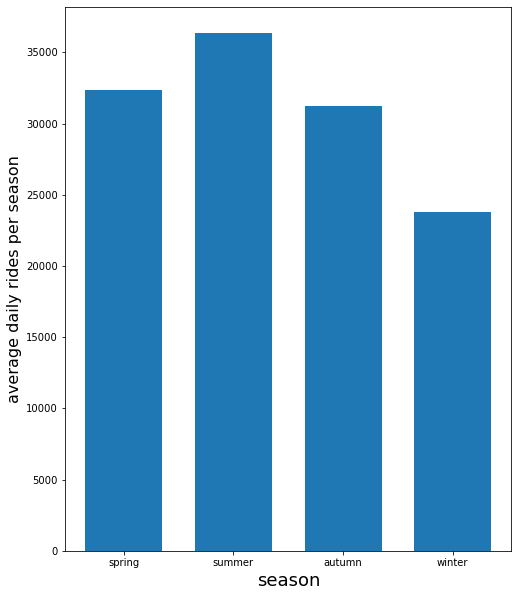

In [220]:
plt.figure(figsize=(8,10))
plt.title('')
names = ["spring", "summer", "autumn", "winter"]
values = [spring, summer, autumn, winter]
plt.bar(names, values, width=0.7)
plt.xlabel('season', fontsize=18)
plt.ylabel('average daily rides per season', fontsize=16)
plt.show()

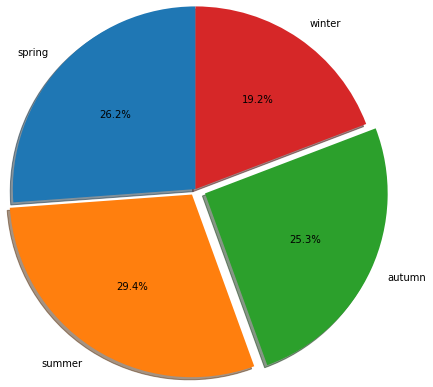

In [221]:

labels = 'spring', 'summer', 'autumn', 'winter'
sizes = [spring, summer, autumn, winter]
explode = (0, 0.05, 0.08, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, radius=1.4)
plt.show()

As the graph reveals, summer is the most popular season for cycling in the city. Accordingly to common sense, the cold and wet seasons are a big deterrent for bikers.

## Analysis between day/night

here we are analysing when the users prefer riding




In [44]:
#Check between day and night
def find_night(data):
    hour_start = 18
    hour_mid1 = 0
    hour_mid2 = 23
    hour_end = 6
    
    current_hour = int(data['hour'][0:2])
    
    curret_hour = 3
    
    if current_hour < hour_end and current_hour >= hour_mid1: #night
        return True
    elif current_hour > hour_start and current_hour <= hour_mid2: #night
        return True
    elif current_hour > hour_end and current_hour <= hour_start: #day
        return False

In [45]:
#Find the data for the nights
rdd_night = rdd['2018'].filter(lambda x: find_night(x))


#Count the number of users during the night
#night_data = rdd_night.map(lambda x: x['user_type']).count()
rdd_night.count()

85857

In [46]:
#Find the data for the days
rdd_day = rdd['2018'].filter(lambda x: not(find_night(x))) #we do not so true-->false

#Count the number of users during the day
#day_data = rdd_day.map(lambda x: x['user_type']).count()
day_count = rdd_day.count()

In [ ]:
night_count
day_count

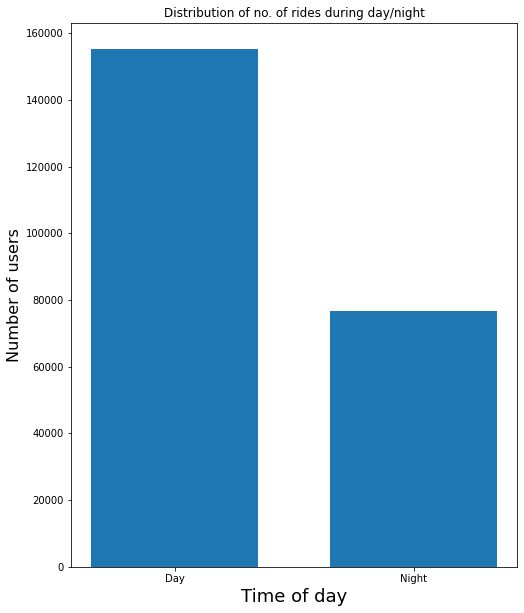

In [78]:
#Plotting the figure
plt.figure(figsize=(8,10))
plt.title('Distribution of no. of rides during day/night')
names = ['Day', 'Night']#list(user_data.keys()) 
values = [day_data,night_data] #list(user_data.values())
plt.bar(names, values, width=0.7)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Number of users', fontsize=16)
names.sort()
plt.xticks(names, ["Day","Night"])
plt.show()

CONCLUSIONS,

As we expected, there are more rides in the day than in the night. We can see that during the day there are more than 2000000 rides, but at night there are less than 1500000.

Now we are looking to se how the distribution of the user type changes during the day and night. We use the rdd_day/rdd_night that we created before to filter into day and night.

In [49]:
#Separate by user type during day
day_user = rdd_day.map(lambda x: x['user_type']).countByValue()
day_user

defaultdict(int, {1: 155676, 2: 2313, 3: 19856})

In [47]:
#Separate by user type during night
night_user = rdd_night.map(lambda x: x['user_type']).countByValue()
night_user

defaultdict(int, {1: 76323, 2: 566, 3: 8968})

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (6,).

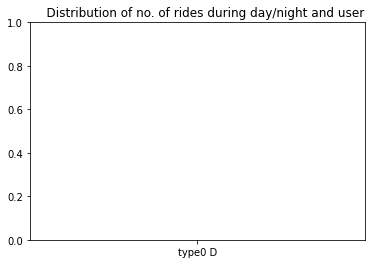

In [52]:
#Plotting the figure
plt.title('    Distribution of no. of rides during day/night and user')
names = ['type0 D', 'type1 D', 'type2 D', 'type3 D', 'type0 N', 'type1 N', 'type2 N', 'type3 N']


#total users
values = list(day_user.values()) + list(night_user.values())
plt.bar(names, values, width=1)
plt.xlabel('User type and time of day', fontsize=20)
plt.ylabel('Number of users', fontsize=16)
plt.show()

#procentage
value_day = [x/day_data for x in list(day_user.values())]
value_night= [x/night_data for x in list(night_user.values())]
values = value_day+value_night
plt.bar(names, values, width=1)
plt.xlabel('User type and time of day', fontsize=20)
plt.ylabel('Percentage of users', fontsize=16)
plt.show()

As we mentioned previously, there are more rides in the day than in the night, so we are going to focus here on the percetage rather than the total number of riders. As we can see, type 0 (not defined type) is has the greatest percentage in the day and in the night (more or less 90%), whereas type 2 (occasional users) has a percentage of less than 10%.



Now we are going to compare the ages of the bike users and compare them to see if there is any difference between day and night.

In [41]:
#Separate by age range
age_data = rdd['2018'].map(lambda x: x['age']).countByValue()
age_data

defaultdict(int,
            {5: 57835,
             0: 71343,
             3: 20207,
             4: 102091,
             1: 7242,
             2: 3586,
             6: 1398})




Now we are going to compare the length of the bike rides and compare them to see if there is any difference between day and night.

In [125]:
#Separate by age range
age_data = rdd['2018'].map(lambda x: x['age']).countByValue()
age_data = sorted(dict(age_data).items(), key=lambda x:x[0])
age_data = [age_data[0][1], age_data[1][1], age_data[2][1], age_data[3][1], age_data[4][1], age_data[5][1], age_data[6][1]]


1829

In [139]:
#Plotting the figure
plt.title('Distribution of the age')
names = ['0','1','2','3','4','5','6']
values = age_data
plt.bar(names, values)
plt.xlabel('Age range', fontsize=18)
plt.ylabel('Number of users', fontsize=16)
names.sort()
plt.xticks(names, ['0','1','2','3','4','5','6'] )
plt.show()

5430

In [ ]:
#Separation during the day with age range
day_age = rdd_day.map(lambda x: x['age']).countByValue()

In [ ]:
#Separation during the night with age range
night_age = rdd_night.map(lambda x: x['age']).countByValue()

In [ ]:
#Plotting the figure
plt.figure(figsize=(12,8))
plt.title('Distribution of no. of rides during day/night and age range')
names = ['0 Day', '1 Day', '2 Day', '3 Day', '4 Day', '5 Day', '6 Day', '0 Night', '1 Night', '2 Night', '3 Night', '4 Night', '5 Night', '6 Night']

#procentage
value_day = [x/day_data for x in list(day_age.values())]
value_night= [x/night_data for x in list(night_age.values())]
values = value_day+value_night
plt.bar(names, values, width=0.7)
plt.xlabel('Age range and time of day', fontsize=18)
plt.ylabel('Percentage of users', fontsize=16)
plt.show()

CONCLUSIONS,

Comparig the range of ages of the riders in the day and in the night we can see a lot of differences. For example the young with 17-18 years old are the biggest users in the day, but this number drastically decreases in the night. Younger people from 0 to 16 years old are one of the biggest users both in the day and in the night. In addition the 'not defined' type increase by a lot in the night and the little number of users from 27 to 40 years old that use the bike in the day, go close to zero in the night. In the end the users from 19 to 26 years old usually use the bike more in the night.

In [28]:
sc.stop()